# Employee Attrition Prediction

In [19]:
options(warn=-1)

In [20]:
library(data.table)
library(entropy)
library(ggplot2)
library(caTools)
library(ROCR)
library(rpart)
library(e1071)
library(rpart)
library(rpart.plot)
library(caret)
library(corrplot)
library(pROC)

In [21]:
attrition_dat = fread("employee_attrition.csv")

In [22]:
# Checking the dimension of data
dim(attrition_dat)

[1] 1470   35

In [23]:
head(attrition_dat)

Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


In [24]:
## check null values 
sum(is.na(attrition_dat))

[1] 0

# Data exploration

In [25]:
# Checking the classes of columns in overall dataset
# unlist(lapply(attrition_dat, class))
str(attrition_dat)

Classes ‘data.table’ and 'data.frame':	1470 obs. of  35 variables:
 $ Age                     : int  41 49 37 33 27 32 59 30 38 36 ...
 $ Attrition               : chr  "Yes" "No" "Yes" "No" ...
 $ BusinessTravel          : chr  "Travel_Rarely" "Travel_Frequently" "Travel_Rarely" "Travel_Frequently" ...
 $ DailyRate               : int  1102 279 1373 1392 591 1005 1324 1358 216 1299 ...
 $ Department              : chr  "Sales" "Research & Development" "Research & Development" "Research & Development" ...
 $ DistanceFromHome        : int  1 8 2 3 2 2 3 24 23 27 ...
 $ Education               : int  2 1 2 4 1 2 3 1 3 3 ...
 $ EducationField          : chr  "Life Sciences" "Life Sciences" "Other" "Life Sciences" ...
 $ EmployeeCount           : int  1 1 1 1 1 1 1 1 1 1 ...
 $ EmployeeNumber          : int  1 2 4 5 7 8 10 11 12 13 ...
 $ EnvironmentSatisfaction : int  2 3 4 4 1 4 3 4 4 3 ...
 $ Gender                  : chr  "Female" "Male" "Male" "Female" ...
 $ HourlyRate              :

In [26]:
## converting categorical columns to factors
cat_cols = c("Attrition","BusinessTravel","Department","Education","EducationField","EnvironmentSatisfaction","Gender",
             "JobInvolvement","JobLevel","JobRole","JobSatisfaction","MaritalStatus","Over18","OverTime",
             "PerformanceRating","RelationshipSatisfaction","StandardHours","StockOptionLevel","WorkLifeBalance")

attrition_dat[,cat_cols] <-  lapply(attrition_dat[,cat_cols,with=FALSE], as.factor)

In [27]:
# Checking summary of data to know about the distribution of data
summary(attrition_dat)

      Age        Attrition            BusinessTravel   DailyRate     
 Min.   :18.00   No :1233   Non-Travel       : 150   Min.   : 102.0  
 1st Qu.:30.00   Yes: 237   Travel_Frequently: 277   1st Qu.: 465.0  
 Median :36.00              Travel_Rarely    :1043   Median : 802.0  
 Mean   :36.92                                       Mean   : 802.5  
 3rd Qu.:43.00                                       3rd Qu.:1157.0  
 Max.   :60.00                                       Max.   :1499.0  
                                                                     
                  Department  DistanceFromHome Education
 Human Resources       : 63   Min.   : 1.000   1:170    
 Research & Development:961   1st Qu.: 2.000   2:282    
 Sales                 :446   Median : 7.000   3:572    
                              Mean   : 9.193   4:398    
                              3rd Qu.:14.000   5: 48    
                              Max.   :29.000            
                                         

In [28]:
# List of continuous variables in data
cont_vars <- c("Age", "DailyRate","DistanceFromHome","HourlyRate","MonthlyIncome","MonthlyRate",
               "NumCompaniesWorked","PercentSalaryHike","TotalWorkingYears","TrainingTimesLastYear",
               "YearsAtCompany", "YearsInCurrentRole",  "YearsSinceLastPromotion","YearsWithCurrManager",
               "EmployeeCount")

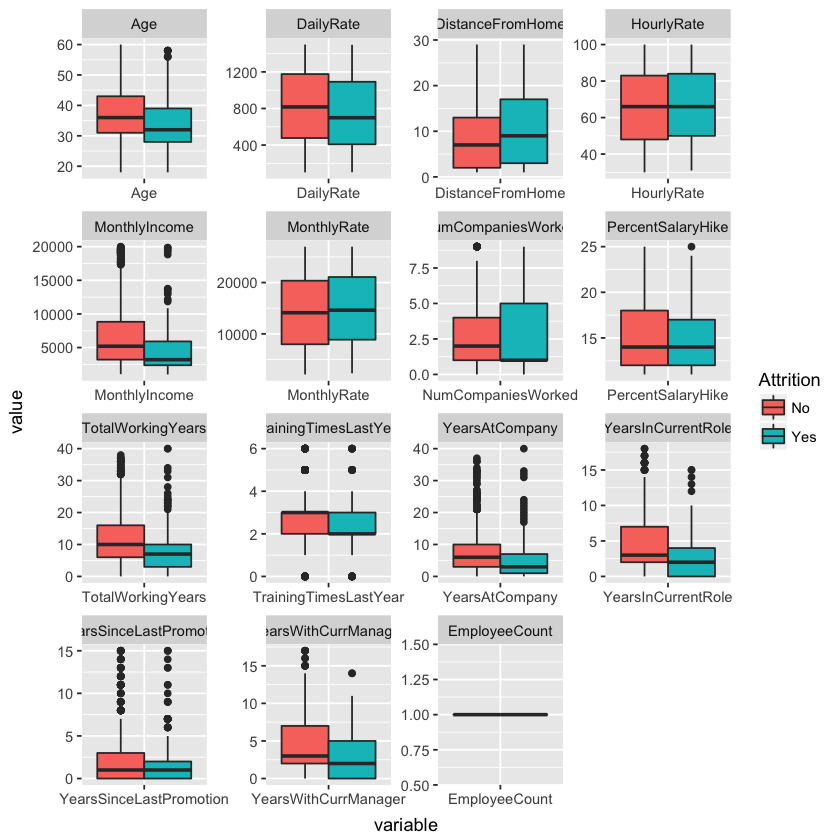

In [29]:
# Distribution of continious variables across attrition
melt_attrition_dat = melt(attrition_dat[,c("Attrition", cont_vars),with=FALSE], id.var = "Attrition")
p <- ggplot(data = melt_attrition_dat , aes(x=variable, y=value)) + geom_boxplot(aes(fill= Attrition))
p <- p + facet_wrap( ~ variable, scales="free")
p

From the above plots we observe that certain variables like _YearsWithCurrManager_,_YearsInCurrentRole_ follow different distributions for churned and non churned employees.

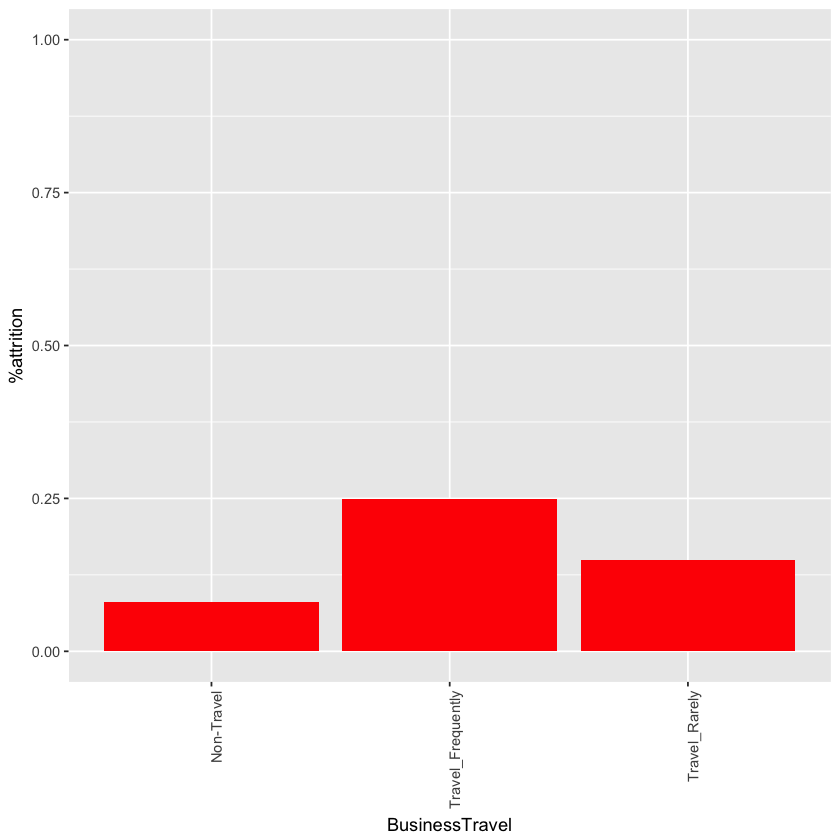

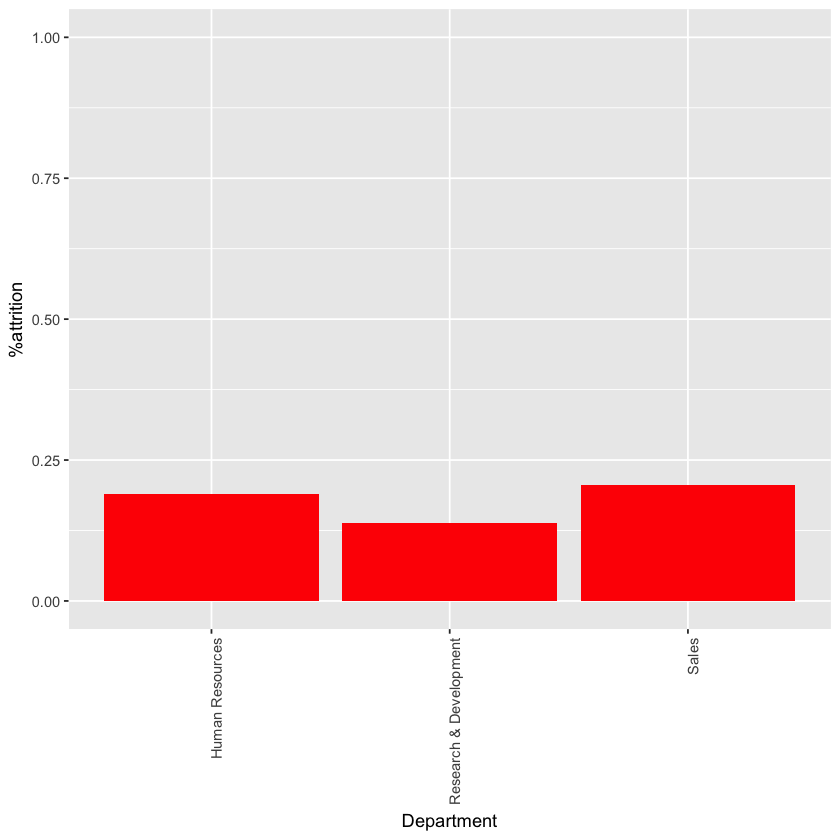

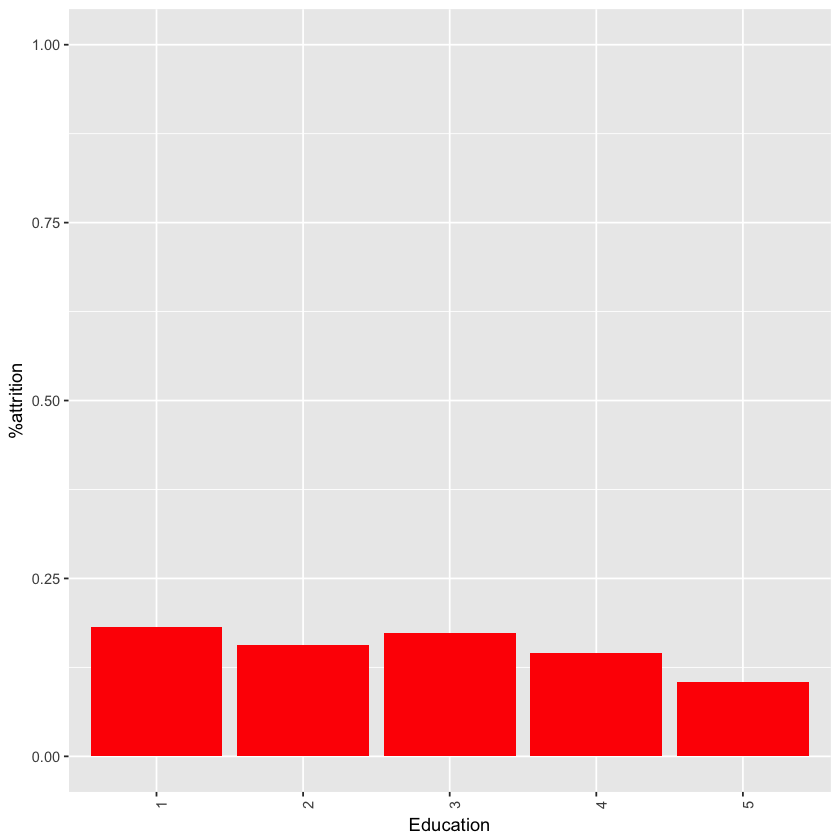

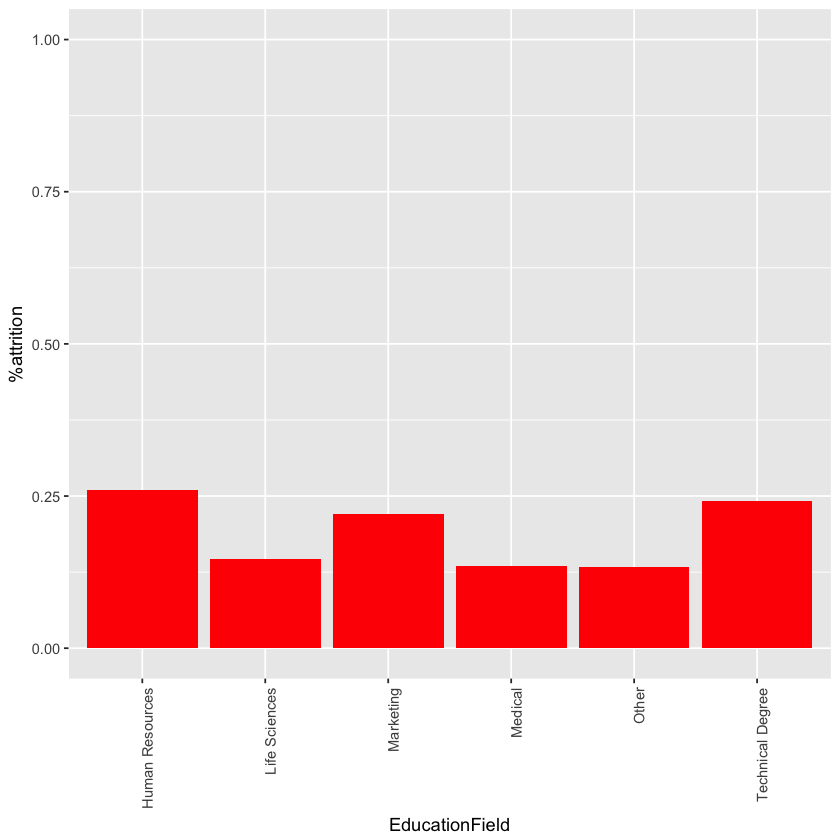

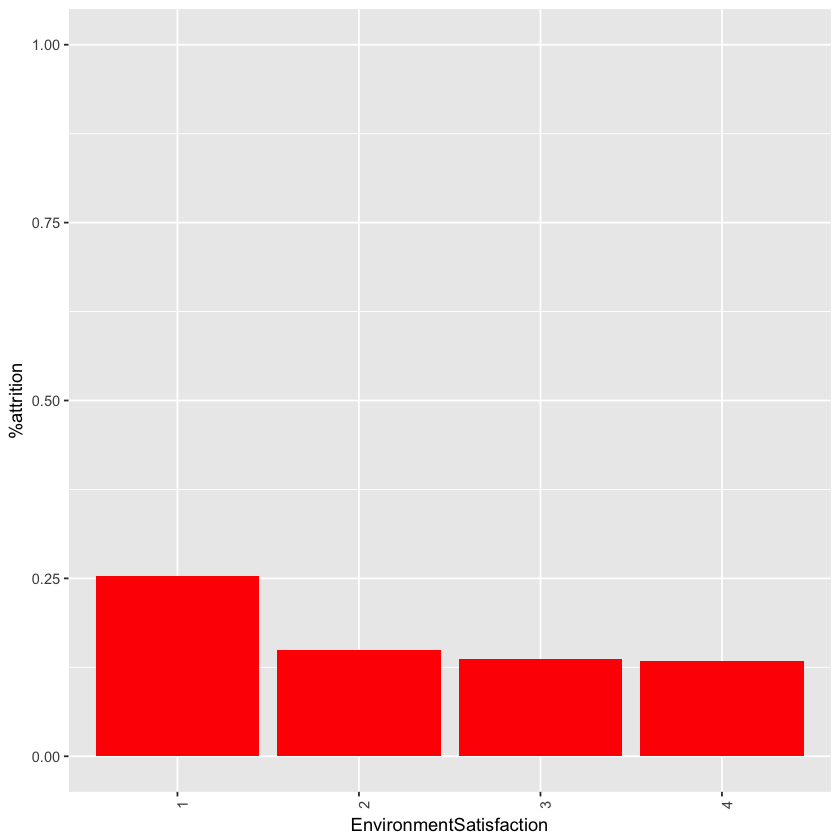

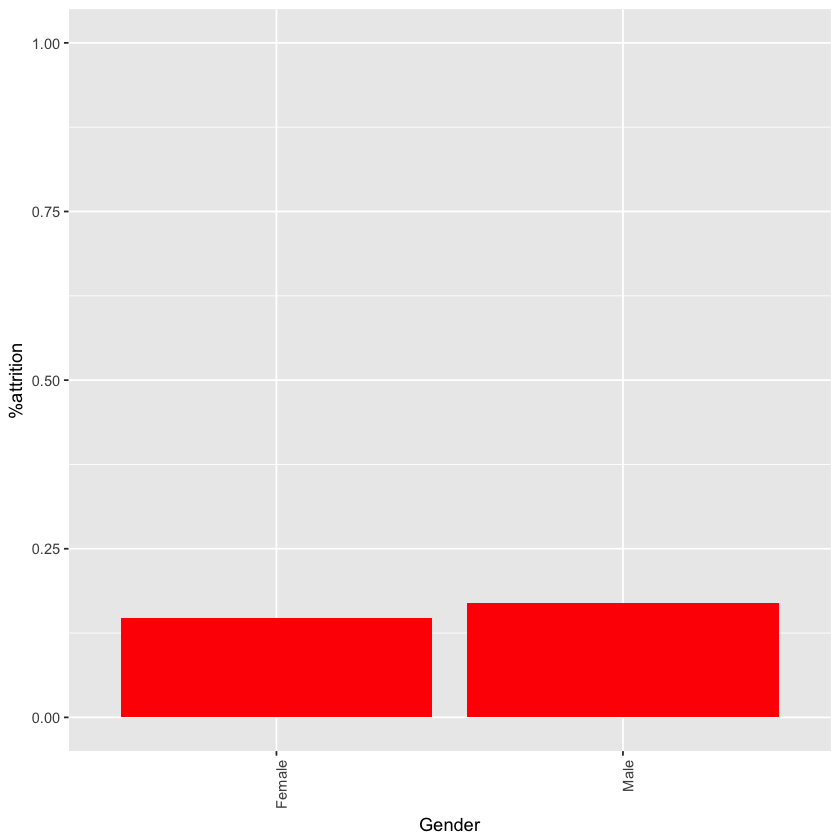

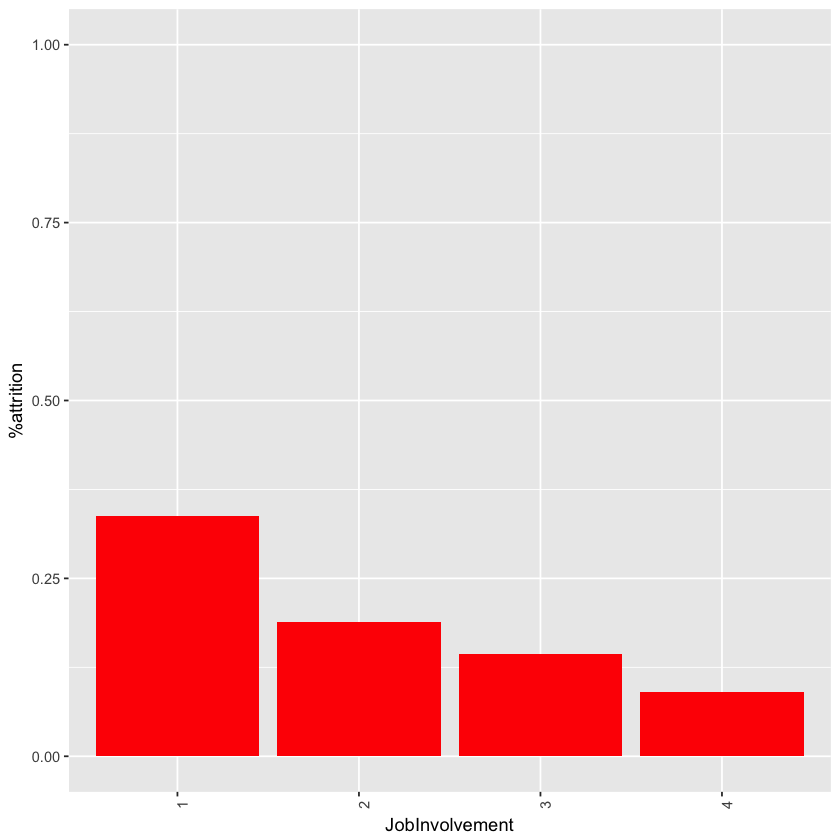

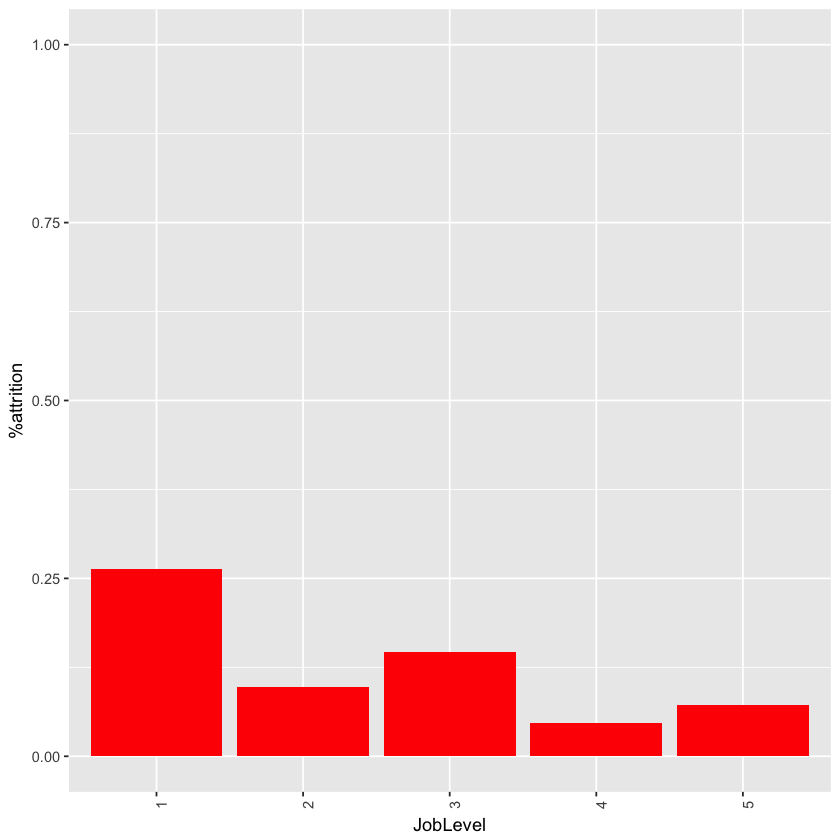

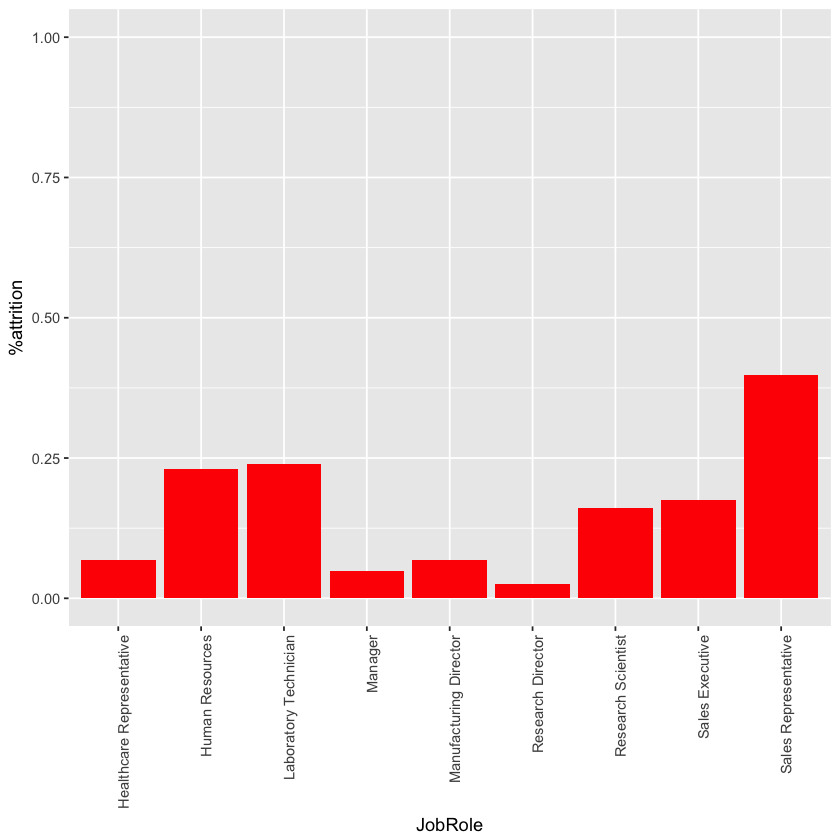

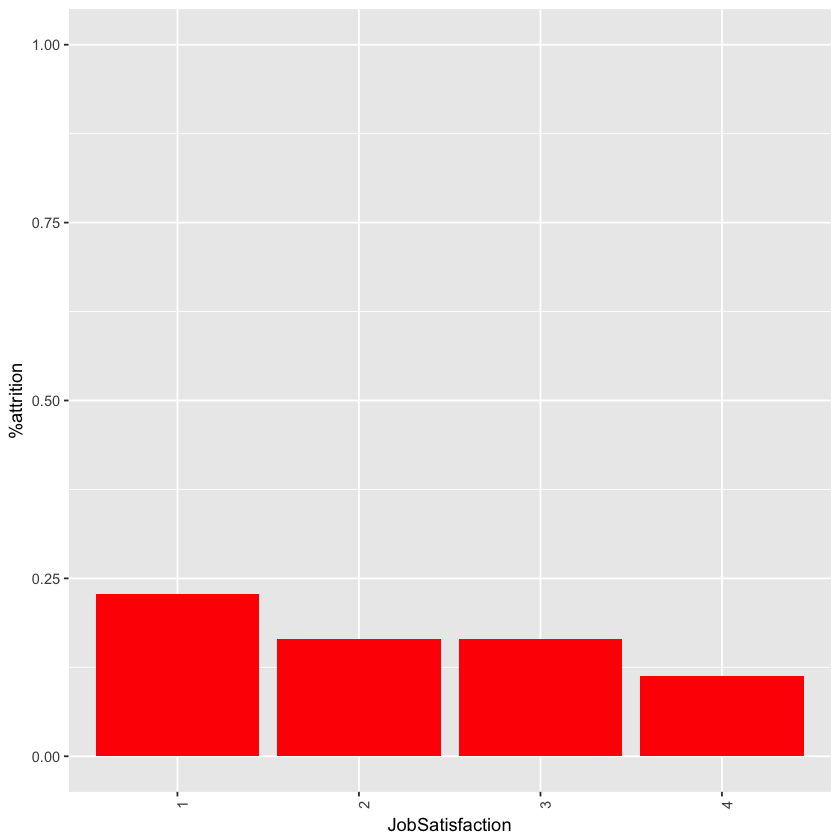

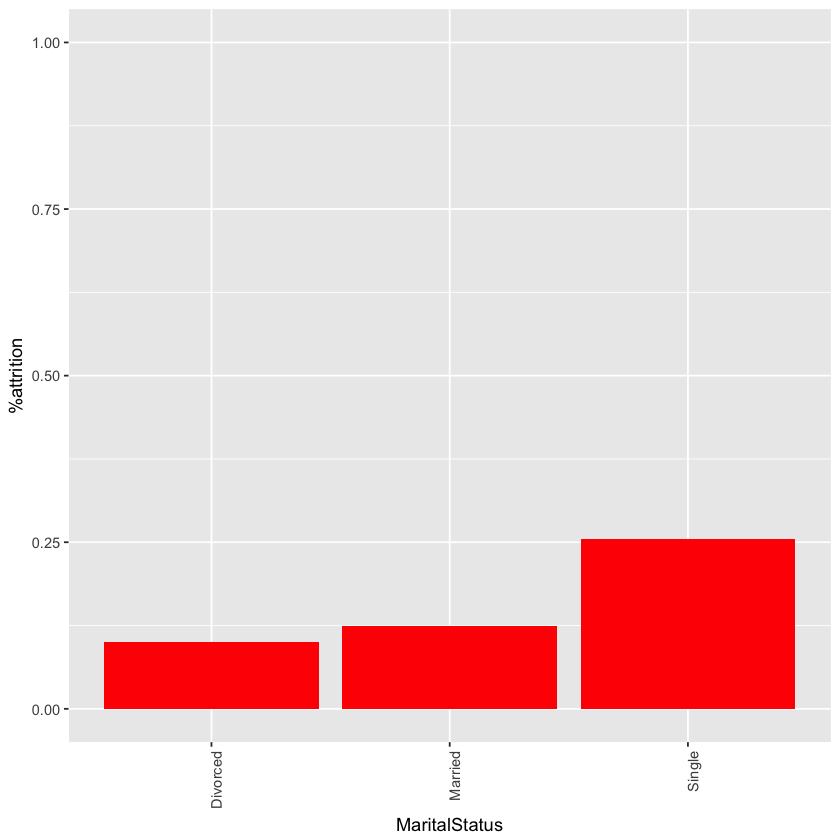

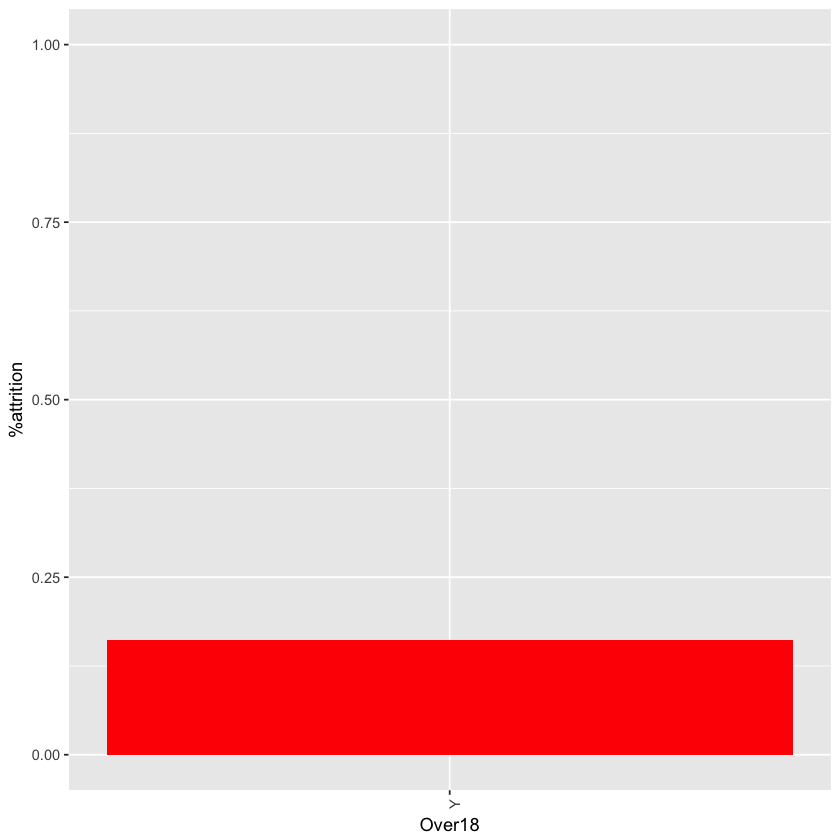

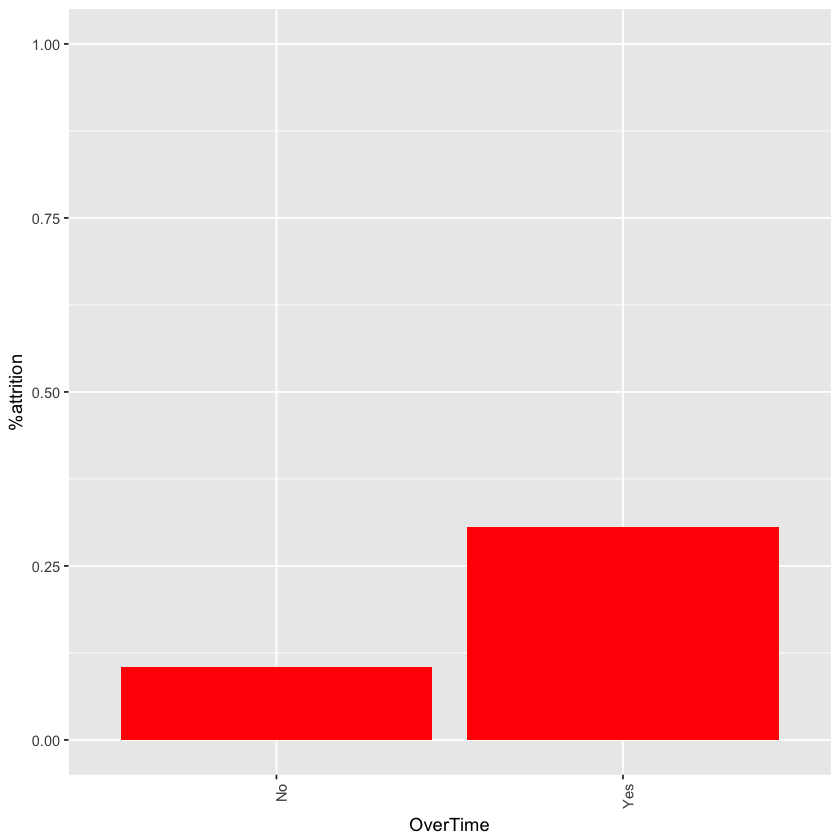

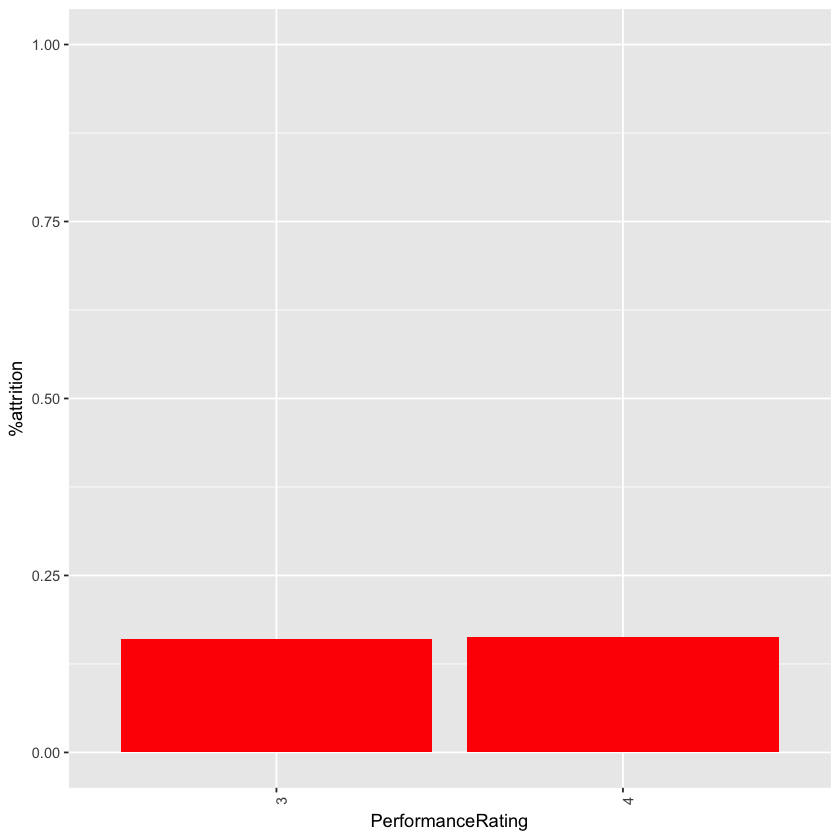

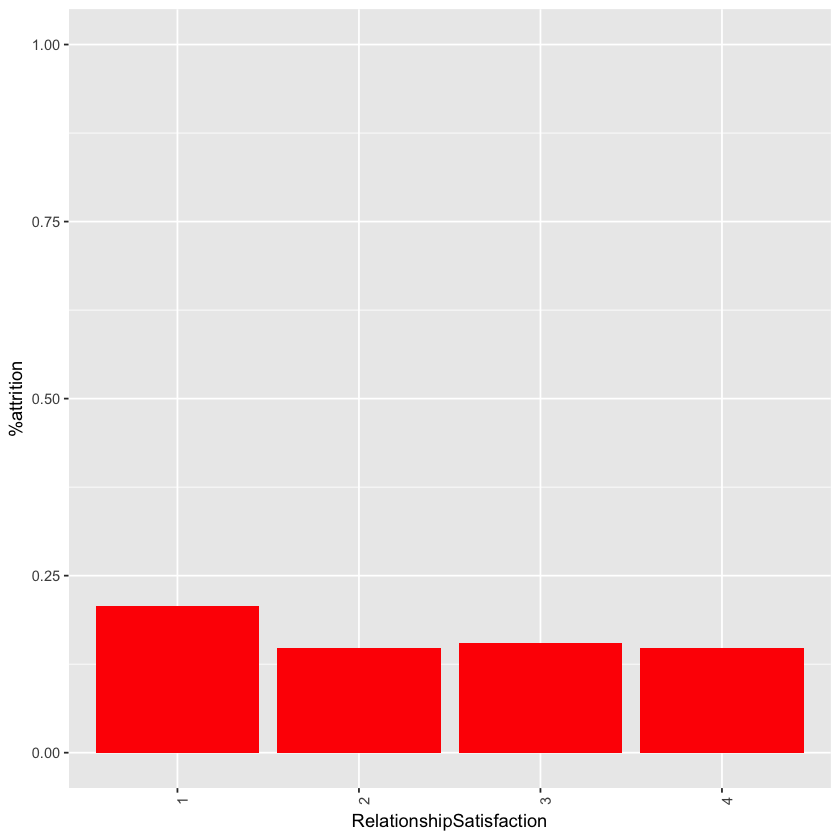

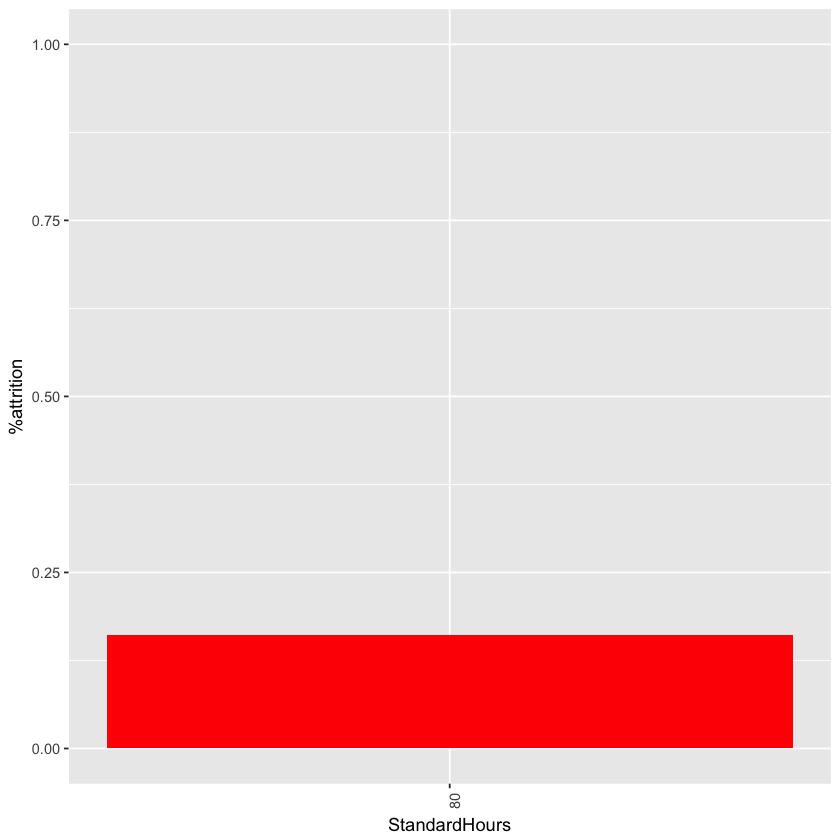

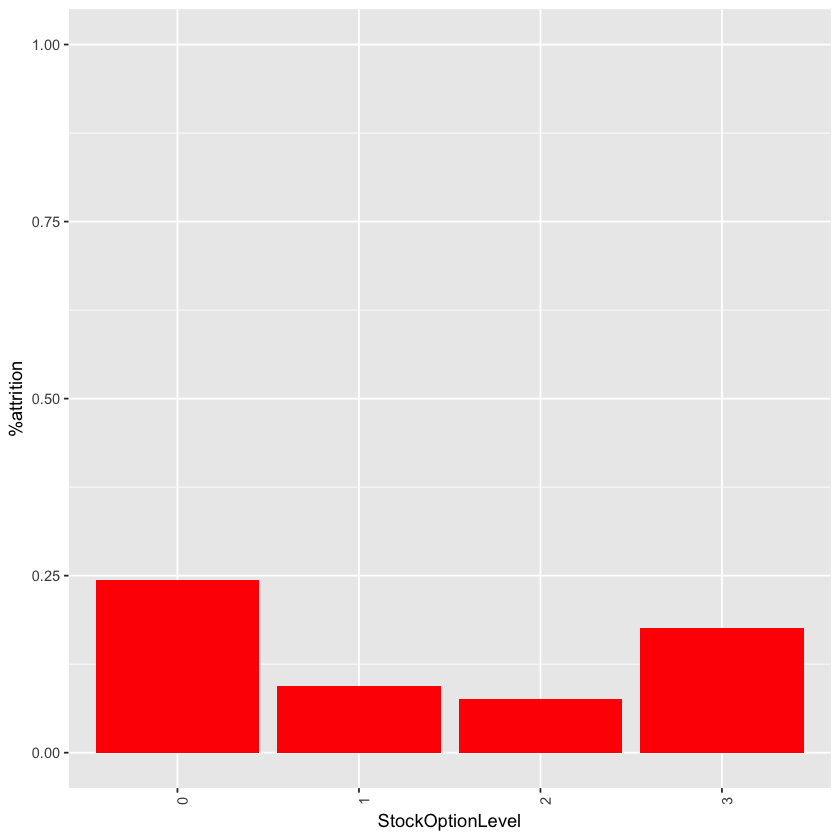

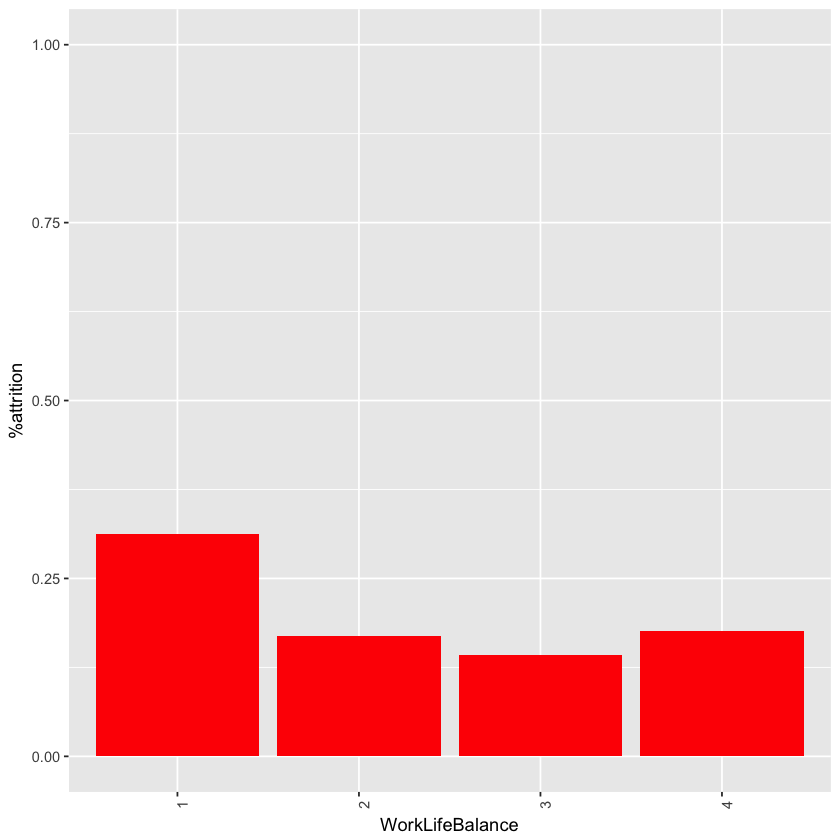

In [30]:
### % attrition across categorical variables
freq_tbl <-  apply(attrition_dat[,cat_cols,with=FALSE],2, function(x) table(attrition_dat$Attrition,x))
freq_tbl <- lapply(freq_tbl,function(x) as.data.frame.matrix(x))
 
perc_attrition_plot <- list()
i =0
for(name in names(freq_tbl)[-1]){
    i <- i +1
    var_data <- data.frame(apply(freq_tbl[name][[1]],2, function(x) x[2]/sum(x)))
    colnames(var_data) <- name
    my_plot <- ggplot(data=var_data, aes(x=row.names(var_data), y=var_data[,name])) +  geom_bar(stat="identity",fill='red') +
        ylim(0.0,1.0) + ylab("%attrition") + xlab(name) + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    plot(my_plot)
    remove(my_plot)
}

From the above plots we see that percentage churn is more for employees who are single, do over time, travel frequently and have less worklife balance satisfaction.

Also churn percentage is high in employees who belong to the Human resource, Sales and Laboratory Technician job roles.

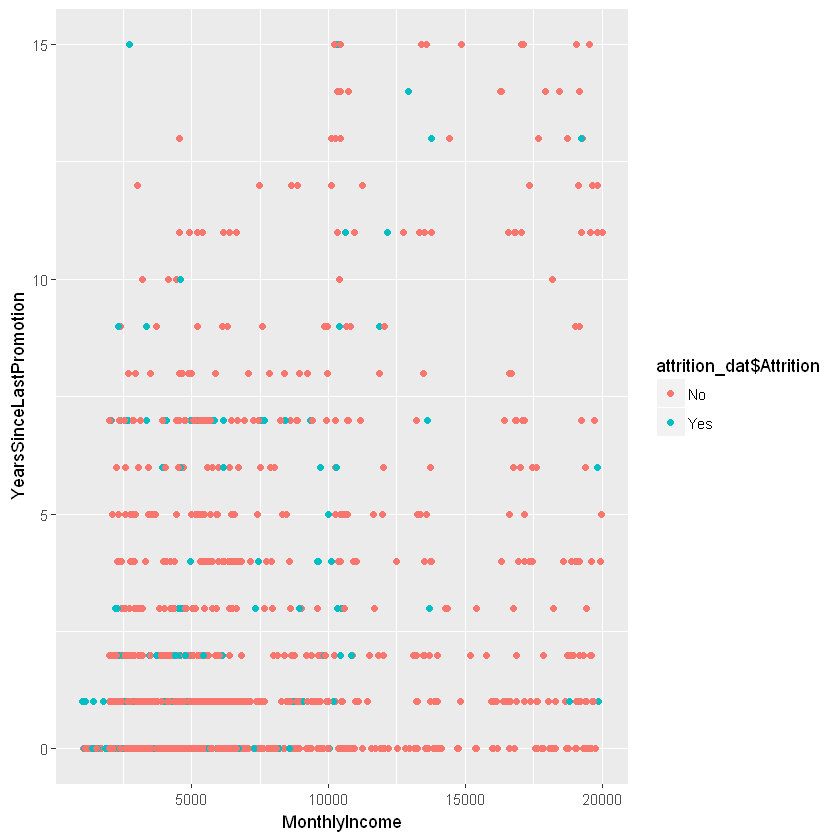

In [13]:
### % Hike vs salary color by attrition
ggplot(data = attrition_dat,aes(x = MonthlyIncome,y = YearsSinceLastPromotion,color=attrition_dat$Attrition )) + geom_point()

In [14]:
# Making correlation matrix for numeric variables
corrmat_cont_vars <- cor(attrition_dat[,setdiff(cont_vars,"EmployeeCount"),with=FALSE])

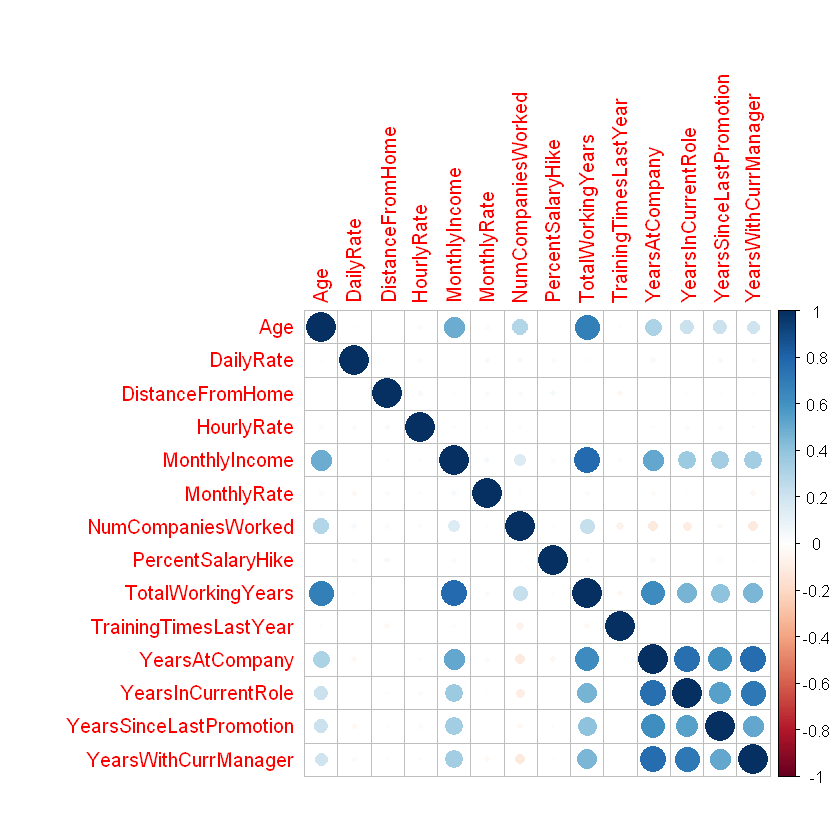

In [15]:
# Plotting correlation plot
corrplot(corrmat_cont_vars)

# Feature Selection
** Pre-modeling feature selection (variance and entropy based) **

In [16]:
normalised_entropy_cat_vars = unlist(lapply(attrition_dat[,cat_cols,with=FALSE],function(x) entropy(table(x)/length(unique(x[!is.na(x)])))))/unlist(lapply(attrition_dat[,cat_cols,with=FALSE], function(x) log2(length(x[!is.na(x)]))))
low_entropy_variables = names(normalised_entropy_cat_vars[normalised_entropy_cat_vars ==0])


# normalised_attrition_data <- attrition_dat[,cont_vars,with=FALSE]
variance_cont_vars <- apply(attrition_dat[,cont_vars,with=FALSE],2, function(x) (x-min(x))/(max(x)-min(x)))
variance_cont_vars <- as.data.frame.matrix(variance_cont_vars)
variance_cont_vars <- apply(variance_cont_vars,2,var)
low_variance_vars <- names(variance_cont_vars[is.na(variance_cont_vars)==TRUE ])

print(paste(c("Variables with low entropy: ",low_entropy_variables),collapse = " "))
print(paste(c("Variables with low variance: ",low_variance_vars),collapse = " "))

[1] "Variables with low entropy:  Over18 StandardHours"
[1] "Variables with low variance:  EmployeeCount"


Removing variables with low variance and low entropy

In [17]:
attrition_dat1 <- attrition_dat[,-c(low_entropy_variables,low_variance_vars,"EmployeeNumber"),with=FALSE]
dim(attrition_dat1)

[1] 1470   31

Normalising contionious variables

In [18]:
attrition_dat1[,cont_vars[!(cont_vars %in% low_variance_vars)]] <- as.data.frame.matrix(apply(attrition_dat[,cont_vars[!(cont_vars %in% low_variance_vars)],with=FALSE],2, function(x) (x-min(x))/(max(x)-min(x))))

In [19]:
dim(attrition_dat1)

[1] 1470   31

In [20]:
"Attrition"
table(attrition_dat1$Attrition)

[1] "Attrition"


  No  Yes 
1233  237 

**Baseline model :**

We can see that out of 1470 employees only 237 have churned labeled with - "Yes". Before building any model lets consider using a simple baseline method.In a classification problem a stadard baseline method is to just predict the most frequent outcome for all observations. Since the label - "No" for Attrition column is most common in this case we will predict that all employees
dont churn.
If we did this then we would get 1233 out of 1470 as correct and we will have an accuracy of :
1233/1470 --> 0.8387 i.e. 83 %
We will try to beat this accuracy while building model

** Spliting data into training and testing using Stratified sampling **

We will split data in the ratio of of 75:25 for training and testing. _sample.split_ randomly splits data in ratio mention but it also makes sure that the target variable is well balanced in each piece.
We saw earlier that in our data about 83 % employees have not churned yet this function makes sure that in our training and testing set also aroud 83 % employees are those who have not churned. We need to do this so that our testing and training set is representative of our complete data.

In [21]:
set.seed(90)
split = sample.split(attrition_dat1$Attrition,SplitRatio = 0.75)
attrition_train <- subset(attrition_dat1,split == TRUE)
attrition_test <- subset(attrition_dat1,split == FALSE)

print(c("Row in Train",nrow(attrition_train)))
print(c("Row in Test", nrow(attrition_test)))

[1] "Row in Train" "1103"        
[1] "Row in Test" "367"        


Distribution of churn in Train

In [22]:
table(attrition_train$Attrition)


 No Yes 
925 178 

Distribution of churn in test

In [23]:
table(attrition_test$Attrition)


 No Yes 
308  59 

# Model building
### Logistic regression

In [24]:
set.seed(101)
attr_log <- glm(Attrition ~ ., data = attrition_train,family = 'binomial')
summary(attr_log)


Call:
glm(formula = Attrition ~ ., family = "binomial", data = attrition_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9181  -0.4458  -0.2003  -0.0585   3.5909  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -11.58107  701.37473  -0.017 0.986826    
Age                               -2.12879    0.71744  -2.967 0.003005 ** 
BusinessTravelTravel_Frequently    2.17851    0.54654   3.986 6.72e-05 ***
BusinessTravelTravel_Rarely        1.44665    0.50631   2.857 0.004273 ** 
DailyRate                         -0.65532    0.38413  -1.706 0.088013 .  
DepartmentResearch & Development  14.39145  701.37348   0.021 0.983629    
DepartmentSales                   13.32733  701.37414   0.019 0.984840    
DistanceFromHome                   1.32729    0.38950   3.408 0.000655 ***
Education2                         0.21184    0.39786   0.532 0.594423    
Education3                         0.202

We see here that the coefficients for many variables came as significant. We also need to look at the AIC value in the output.This is a measure of the quality of the model. It can only be compared between models on the same data set.But it provides a means for model selection.The preferred model is the one with the minimum AIC.

** Note ** - R converts factor variables into dummy variables by default

In [25]:
### Predicting for test data
predict_test = predict(attr_log,newdata = attrition_test,type = 'response')

** THRESHOLDING : **
Outcome of a logistic regression model is a probability.
Often, we want to make an actual prediction.
We can convert the probabilities to predictions using what's called a threshold value, t.
If the probability of attrition is greater than this threshold value, t, we predict that employee will churn.
But if the probability of attrition is less than the threshold value, t, then we predict that employee will not churn.

If we pick a large threshold value t,then we will predict actual churn rarely,
since the probability of attrition has to be really large to be greater than the threshold.
This means that we will make more errors where we say that employee will not churn , but it's actually churning case.

On the other hand, if the threshold value, t, is small,we predict churn (Yes) frequently, and we predict non churn (No) rarely.
This means that we will make more errors where we say that employee will not churn, but it's actually that employee will churn.



A model with a higher threshold will have a lower sensitivity and a higher specificity.
A model with a lower threshold will have a higher sensitivity and a lower specificity.

To prove the above statements we try various thresholds( 0.5,0.7.0.1) and analyzing the results

** Threshold - 0.5 **

In [26]:
print("Confusion matrix for threshold 0.5")

thershold= 0.5

confusion_mat <- table(attrition_test$Attrition, predict_test > thershold)
confusion_mat
# sensitivity tpr --> sensitivity = tp/(tp+FN)
tp <- confusion_mat[4]
tp_plus_fn <- confusion_mat[4] + confusion_mat[2]

sensitivity <- tp/tp_plus_fn
print(c("sensitivity",sensitivity))

# specificity tnr--> specificity = tn/(tn+FP)
tn <- confusion_mat[1]
tn_plus_fp <- confusion_mat[1] + confusion_mat[3]

specificity <- tn/tn_plus_fp
print(c("specificity",specificity))

[1] "Confusion matrix for threshold 0.5"


     
      FALSE TRUE
  No    296   12
  Yes    31   28

[1] "sensitivity"       "0.474576271186441"
[1] "specificity"       "0.961038961038961"


** Threshold - 0.7 **

In [27]:
print("Confusion matrix for threshold 0.7")

thershold= 0.7

confusion_mat <- table(attrition_test$Attrition, predict_test > thershold)
confusion_mat
# sensitivity tpr --> sensitivity = tp/(tp+FN)
tp <- confusion_mat[4]
tp_plus_fn <- confusion_mat[4] + confusion_mat[2]

sensitivity <- tp/tp_plus_fn
print(c("sensitivity",sensitivity))

# specificity tnr--> specificity = tn/(tn+FP)
tn <- confusion_mat[1]
tn_plus_fp <- confusion_mat[1] + confusion_mat[3]

specificity <- tn/tn_plus_fp
print(c("specificity",specificity))

[1] "Confusion matrix for threshold 0.7"


     
      FALSE TRUE
  No    304    4
  Yes    45   14

[1] "sensitivity"      "0.23728813559322"
[1] "specificity"       "0.987012987012987"


** Threshold - 0.1 **

In [28]:
print("Confusion matrix for threshold 0.1")

thershold= 0.1
confusion_mat <- table(attrition_test$Attrition, predict_test > thershold)
confusion_mat

# sensitivity tpr --> sensitivity = tp/(tp+FN)
tp <- confusion_mat[4]
tp_plus_fn <- confusion_mat[4] + confusion_mat[2]

sensitivity <- tp/tp_plus_fn
print(c("sensitivity",sensitivity))

# specificity tnr--> specificity = tn/(tn+FP)
tn <- confusion_mat[1]
tnplusFP <- confusion_mat[1] + confusion_mat[3]

specificity <- tn/tnplusFP
print(c("specificity",specificity))

[1] "Confusion matrix for threshold 0.1"


     
      FALSE TRUE
  No    207  101
  Yes     7   52

[1] "sensitivity"      "0.88135593220339"
[1] "specificity"       "0.672077922077922"


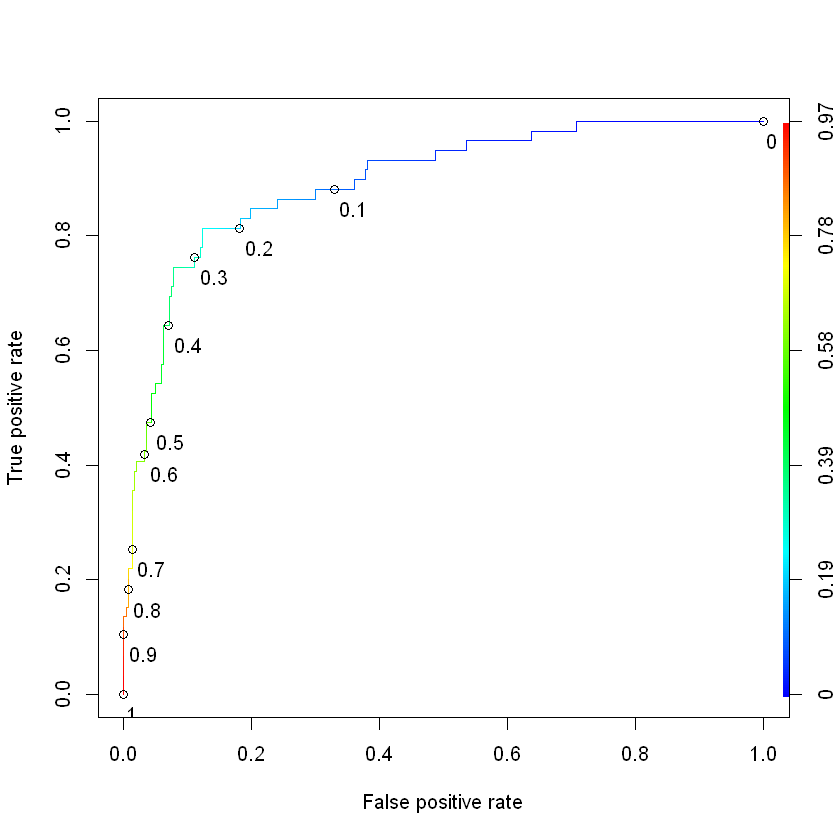

In [29]:
## Plotting Receiver operator characteristics curve to decide better on threshold
rocr_pred_logistic_best_treshold = prediction(predict_test ,attrition_test$Attrition)
rocr_perf_logistic_best_treshold = performance(rocr_pred_logistic_best_treshold,'tpr','fpr')
plot(rocr_perf_logistic_best_treshold,colorize=TRUE,print.cutoffs.at = seq(0,1,.1),text.adj =c(-0.2,1.7))

From the above plot we observe that 0.3 is the best threshold. Now we will evaluate model performance witn this threshold.

In [30]:
thershold_best_log = 0.3

conf_mat_logistic_best_treshold <- table(attrition_test$Attrition ,predict_test > thershold_best_log)
# accuracy
accuracy_logistic_best_treshold <- (conf_mat_logistic_best_treshold[1] + conf_mat_logistic_best_treshold[4])/(conf_mat_logistic_best_treshold[1]+conf_mat_logistic_best_treshold[2]+conf_mat_logistic_best_treshold[3]+conf_mat_logistic_best_treshold[4])
"Confusion matrix for best threshold (logistic regression)"
conf_mat_logistic_best_treshold
"Model Performance"
print(c("Accuracy",accuracy_logistic_best_treshold))

# sensitivity tpr --> sensitivity = tp/(tp+FN)
tp <- conf_mat_logistic_best_treshold[4]
tp_plus_fn <- conf_mat_logistic_best_treshold[4] + conf_mat_logistic_best_treshold[2]

sensitivity_logistic_best_treshold <- tp/tp_plus_fn
print(c("sensitivity",sensitivity_logistic_best_treshold))

# specificity tnr--> specificity = tn/(tn+FP)
tn <- confusion_mat[1]
tn_plus_fp <- conf_mat_logistic_best_treshold[1] + conf_mat_logistic_best_treshold[3]

specificity_logistic_best_treshold <- tn/tn_plus_fp
print(c("specificity",specificity_logistic_best_treshold))

kappa_logistic_best_treshold = confusionMatrix(factor(predict_test > thershold_best_log), attrition_test$Attrition == 'Yes', positive="TRUE", mode="everything")
kappa_logistic_best_treshold = kappa_logistic_best_treshold$overall['Kappa']
print(kappa_logistic_best_treshold)

[1] "Confusion matrix for best threshold (logistic regression)"

     
      FALSE TRUE
  No    274   34
  Yes    14   45

[1] "Model Performance"

[1] "Accuracy"          "0.869209809264305"
[1] "sensitivity"      "0.76271186440678"
[1] "specificity"       "0.672077922077922"
    Kappa 
0.5737102 


Now we try to reduce the complexity of the model by selecting important features for the model based on p-value. In summary of the model all variables which have p-value less than 0.05 are considered important.

In [31]:
summary_coeff_pval =  as.data.frame.matrix(summary(attr_log)$coef)
summary_coeff_pval[summary_coeff_pval$`Pr(>|z|)` <= 0.05,]

,Estimate,Std. Error,z value,Pr(>|z|)
Age,-2.1287879,0.7174389,-2.967204,3.005211e-03
BusinessTravelTravel_Frequently,2.1785089,0.5465412,3.985992,6.719867e-05
BusinessTravelTravel_Rarely,1.4466526,0.5063112,2.857240,4.273427e-03
DistanceFromHome,1.3272884,0.3895012,3.407662,6.552198e-04
EnvironmentSatisfaction2,-0.8519776,0.3407460,-2.500330,1.240775e-02
EnvironmentSatisfaction3,-1.0206980,0.3108081,-3.284013,1.023401e-03
EnvironmentSatisfaction4,-1.3047147,0.3219381,-4.052689,5.063236e-05
GenderMale,0.5458685,0.2280772,2.393350,1.669531e-02
JobInvolvement2,-1.0670604,0.4378955,-2.436793,1.481818e-02
JobInvolvement3,-1.2338103,0.4051299,-3.045468,2.323184e-03


From above we see that only 15 primary variables are important. Now we will build an a model with only important variables and evaluate the trade off between complexity and accuracy

In [32]:
important_vars_logistic <- c('Age','BusinessTravel','DistanceFromHome','EnvironmentSatisfaction','Gender','JobInvolvement','JobLevel',
                             'JobSatisfaction','NumCompaniesWorked','OverTime','RelationshipSatisfaction',
                             'StockOptionLevel','WorkLifeBalance','YearsSinceLastPromotion', 'YearsWithCurrManager')

In [33]:
set.seed(2001)
attr_log_imp_vars <- glm(Attrition ~ ., data = attrition_train[,c('Attrition' ,important_vars_logistic),with=FALSE],family = 'binomial')
summary(attr_log_imp_vars)


Call:
glm(formula = Attrition ~ ., family = "binomial", data = attrition_train[, 
    c("Attrition", important_vars_logistic), with = FALSE])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8025  -0.4991  -0.2725  -0.1174   3.7790  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       1.7588     0.7959   2.210 0.027123 *  
Age                              -2.5402     0.5877  -4.322 1.55e-05 ***
BusinessTravelTravel_Frequently   1.9227     0.5001   3.844 0.000121 ***
BusinessTravelTravel_Rarely       1.2572     0.4668   2.693 0.007077 ** 
DistanceFromHome                  1.1699     0.3503   3.339 0.000840 ***
EnvironmentSatisfaction2         -0.6931     0.3089  -2.244 0.024850 *  
EnvironmentSatisfaction3         -0.8078     0.2810  -2.875 0.004044 ** 
EnvironmentSatisfaction4         -1.0093     0.2885  -3.499 0.000467 ***
GenderMale                        0.5006     0.2097   2.388 0.016955 * 

In [34]:
predict_test_imp_log <- predict(attr_log_imp_vars,newdata = attrition_test[,c('Attrition' ,important_vars_logistic),with=FALSE],type = 'response')

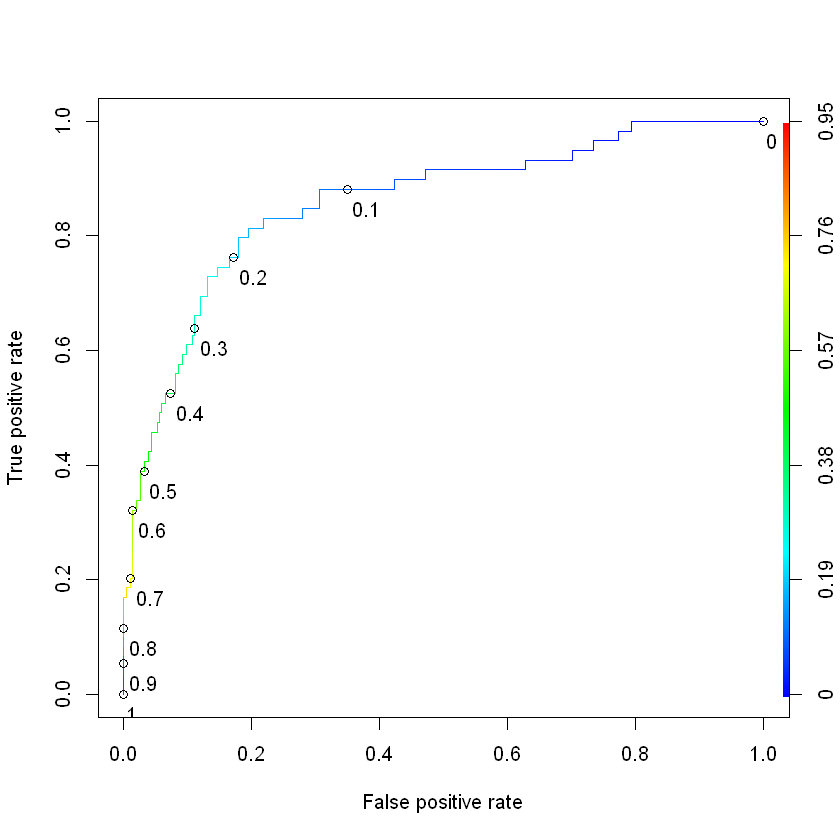

In [35]:
rocr_pred_log_imp_vars = prediction(predict_test_imp_log ,attrition_test$Attrition)
rocr_perf_log_imp_vars = performance(rocr_pred_log_imp_vars,'tpr','fpr')
plot(rocr_perf_log_imp_vars,colorize=TRUE,print.cutoffs.at = seq(0,1,.1),text.adj =c(-0.2,1.7))

From the above plot we observe that 0.3 is the best threshold. Now we will evaluate model performance witn threshold 0.3 

In [36]:
threshold_log_imp_vars = 0.3
conf_mat_log_imp_vars <- table(attrition_test$Attrition ,predict_test_imp_log > threshold_log_imp_vars)
"Confusion matrix model with only important variable"
conf_mat_log_imp_vars
# sensitivity tpr --> sensitivity = tp/(tp+FN)
tp <- conf_mat_log_imp_vars[4]
tp_plus_fn <- conf_mat_log_imp_vars[4] + conf_mat_log_imp_vars[2]

sensitivity_log_imp_vars <- tp/tp_plus_fn
print(c("sensitivity",sensitivity_log_imp_vars))

# specificity tnr--> specificity = tn/(tn+FP)
tn <- conf_mat_log_imp_vars[1]
tn_plus_fp <- conf_mat_log_imp_vars[1] + conf_mat_log_imp_vars[3]

specificity_log_imp_vars <- tn/tn_plus_fp
print(c("specificity",specificity_log_imp_vars))


#Predicting
# accuracy
accuracy_log_imp_vars <- (conf_mat_log_imp_vars[1] + conf_mat_log_imp_vars[4])/(conf_mat_log_imp_vars[1]+conf_mat_log_imp_vars[2]+conf_mat_log_imp_vars[3]+conf_mat_log_imp_vars[4])
print(c("Accuracy" ,accuracy_log_imp_vars))

kappa_log_imp_vars = confusionMatrix(factor(predict_test_imp_log > threshold_log_imp_vars), attrition_test$Attrition == 'Yes', positive="TRUE", mode="everything")
kappa_log_imp_vars = kappa_log_imp_vars$overall['Kappa']
print(c(kappa_log_imp_vars))

[1] "Confusion matrix model with only important variable"

     
      FALSE TRUE
  No    274   34
  Yes    22   37

[1] "sensitivity"       "0.627118644067797"
[1] "specificity"      "0.88961038961039"
[1] "Accuracy"          "0.847411444141689"
    Kappa 
0.4774738 


### Classification and Regression Trees (CART)

In [37]:
set.seed(30001)
cart <- rpart(Attrition ~ ., method="class", data=attrition_train,)

In [38]:
# Predicting for test data
predict_test_cart = as.data.frame.matrix(predict(cart,newdata = attrition_test,type = "prob"))

In [39]:
predict_test_cart = predict_test_cart$Yes

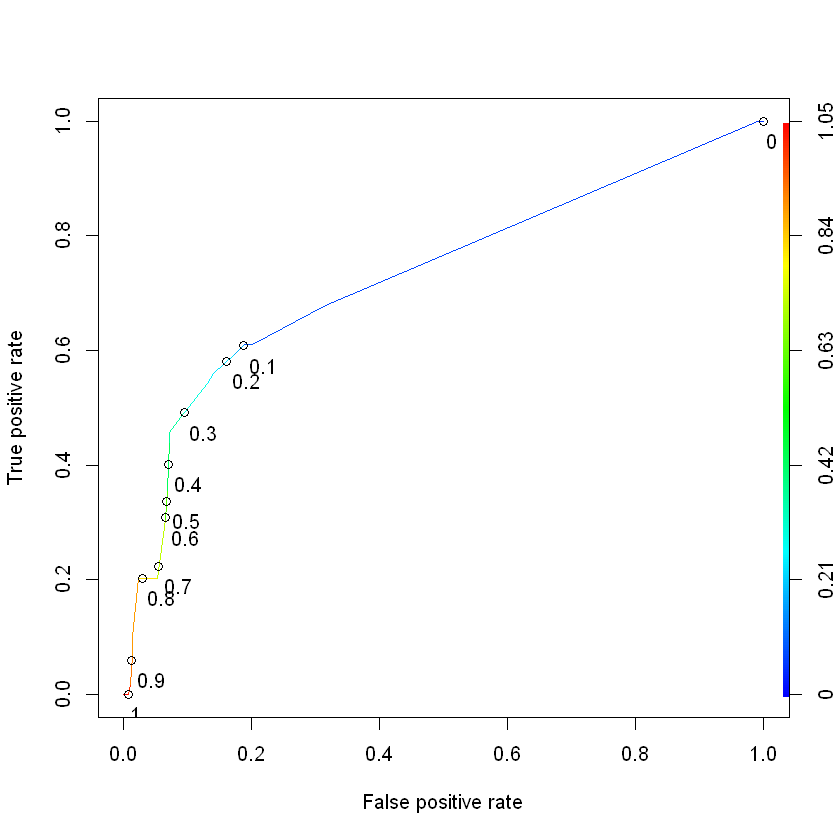

In [40]:
rocr_pred_cart = prediction(predict_test_cart ,attrition_test$Attrition)
rocr_perf_cart = performance(rocr_pred_cart,'tpr','fpr')
plot(rocr_perf_cart,colorize=TRUE,print.cutoffs.at = seq(0,1,.1),text.adj =c(-0.2,1.7))

We see that threshold 0.4 is the best threshold

In [41]:
threshold_cart <- 0.4
conf_mat_cart <- table(attrition_test$Attrition ,predict_test_cart > threshold_cart)


# sensitivity tpr --> sensitivity = tp/(tp+FN)
tp <- conf_mat_cart[4]
tp_plus_fn <- conf_mat_cart[4] + conf_mat_cart[2]

sensitivity_cart <- tp/tp_plus_fn
"sensitivity"
sensitivity_cart

# specificity tnr--> specificity = tn/(tn+FP)
tn <- conf_mat_cart[1]
tn_plus_fp <- conf_mat_cart[1] + conf_mat_cart[3]

specificity_cart <- tn/tn_plus_fp
"specificity"
specificity_cart


#Predicting
# accuracy
accuracy_cart <- (conf_mat_cart[1] + conf_mat_cart[4])/(conf_mat_cart[1]+conf_mat_cart[2]+conf_mat_cart[3]+conf_mat_cart[4])
"Confusion matrix"
conf_mat_cart
"Accuracy of model"
accuracy_cart

kappa_cart = confusionMatrix(factor(predict_test_cart > threshold_cart), attrition_test$Attrition == 'Yes', positive="TRUE", mode="everything")
kappa_cart = kappa_cart$overall['Kappa']
print(c(kappa_cart))

[1] "sensitivity"

[1] 0.3559322

[1] "specificity"

[1] 0.9318182

[1] "Confusion matrix"

     
      FALSE TRUE
  No    287   21
  Yes    38   21

[1] "Accuracy of model"

[1] 0.8392371

    Kappa 
0.3256828 


In [42]:
# Top 10 important variables
sort(cart$variable.importance,decreasing = TRUE)[1:10]

TotalWorkingYears     MonthlyIncome           JobRole  DistanceFromHome 
         28.32960          25.43284          17.30629          16.84060 
         JobLevel  StockOptionLevel               Age          OverTime 
         16.65484          15.57691          14.96038          14.38895 
    MaritalStatus         DailyRate 
         11.72018          10.40741

In [43]:
cart_imp_vars <- names(sort(cart$variable.importance,decreasing = TRUE)[1:10])

In [44]:

cart_model_imp_vars <- rpart(Attrition ~ ., method="class", data=attrition_train[,c("Attrition",cart_imp_vars),with= FALSE])
# summary(cart)
predict_test_cart_model_imp_vars = as.data.frame.matrix(predict(cart_model_imp_vars,newdata = attrition_test[,c("Attrition",cart_imp_vars),with= FALSE],type = "prob"))

predict_test_cart_model_imp_vars = predict_test_cart_model_imp_vars$Yes

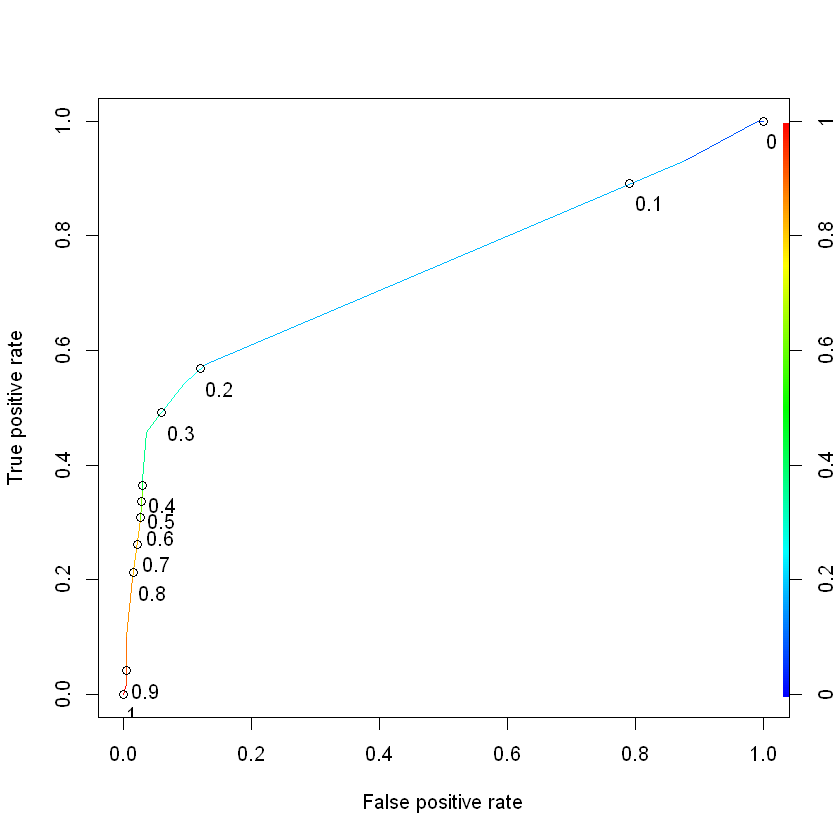

In [45]:
rocr_pred_cart_model_imp_vars = prediction(predict_test_cart_model_imp_vars ,attrition_test$Attrition)
rocr_perf_cart_model_imp_vars = performance(rocr_pred_cart_model_imp_vars,'tpr','fpr')
# plot(rocr_perf)
# plot(rocr_perf,colorize=TRUE)
plot(rocr_perf_cart_model_imp_vars,colorize=TRUE,print.cutoffs.at = seq(0,1,.1),text.adj =c(-0.2,1.7))

In [46]:
threshold_cart_model_imp_vars <- 0.3
conf_mat_cart_model_imp_vars <- table(attrition_test$Attrition ,predict_test_cart_model_imp_vars > threshold_cart_model_imp_vars)


# sensitivity tpr --> sensitivity = tp/(tp+FN)
tp <- conf_mat_cart_model_imp_vars[4]
tp_plus_fn <- conf_mat_cart_model_imp_vars[4] + conf_mat_cart_model_imp_vars[2]

sensitivity_cart_model_imp_vars <- tp/tp_plus_fn
"sensitivity"
sensitivity_cart_model_imp_vars

# specificity tnR--> specificity = tn/(tn+FP)
tn <- conf_mat_cart_model_imp_vars[1]
tn_plus_fp <- conf_mat_cart_model_imp_vars[1] + conf_mat_cart_model_imp_vars[3]

specificity_cart_model_imp_vars <- tn/tn_plus_fp
"specificity"
specificity_cart_model_imp_vars


#Predicting
# accuracy
accuracy_cart_model_imp_vars <- (conf_mat_cart_model_imp_vars[1] + conf_mat_cart_model_imp_vars[4])/(conf_mat_cart_model_imp_vars[1]+conf_mat_cart_model_imp_vars[2]+conf_mat_cart_model_imp_vars[3]+conf_mat_cart_model_imp_vars[4])
"Confusion matrix"
conf_mat_cart_model_imp_vars
"Accuracy of model"
accuracy_cart_model_imp_vars


kappa_cart_model_imp_vars = confusionMatrix(factor(predict_test_cart_model_imp_vars > threshold_cart_model_imp_vars), attrition_test$Attrition == 'Yes', positive="TRUE", mode="everything")
kappa_cart_model_imp_vars = kappa_cart_model_imp_vars$overall['Kappa']
print(c(kappa_cart_model_imp_vars))

[1] "sensitivity"

[1] 0.4576271

[1] "specificity"

[1] 0.9642857

[1] "Confusion matrix"

     
      FALSE TRUE
  No    297   11
  Yes    32   27

[1] "Accuracy of model"

[1] 0.8828338

   Kappa 
0.492817 


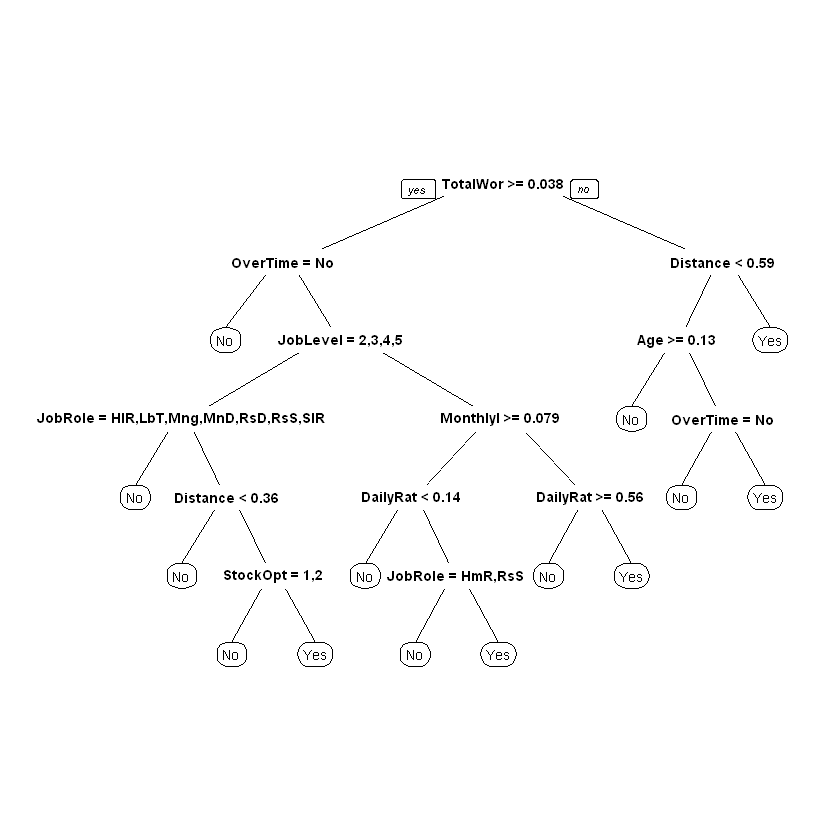

In [47]:
prp(cart_model_imp_vars)

# Feature engineering

Now let us try and improve the model by engineering new features.

In [48]:
attrition_train_new <- attrition_train
attrition_test_new <- attrition_test

In [49]:
is_first_company = attrition_dat$NumCompaniesWorked == 1

In [50]:
loyalty =  attrition_dat$YearsAtCompany/attrition_dat$TotalWorkingYears

In [51]:
## lower the number more volatile is the employee
volatility = attrition_dat$TotalWorkingYears/attrition_dat$NumCompaniesWorked
volatility[which(is.infinite(volatility))] <- attrition_dat$TotalWorkingYears[which(is.infinite(volatility))]

In [52]:
attrition_train_new$IsFirstCompany <- is_first_company[split== TRUE]
attrition_test_new$IsFirstCompany <- is_first_company[split== FALSE]

In [53]:
attrition_train_new$Loyalty <- loyalty[split== TRUE]
attrition_test_new$Loyalty <- loyalty[split== FALSE]

In [54]:
attrition_train_new$Volatility <- volatility[split== TRUE]
attrition_test_new$Volatility <- volatility[split== FALSE]

In [55]:
new_features = c('IsFirstCompany','Loyalty','Volatility')

In [56]:
attr_log_imp_vars_new_ftr <- glm(Attrition ~ ., data = attrition_train_new[,c('Attrition' ,important_vars_logistic,new_features),with=FALSE],family = 'binomial')
summary(attr_log_imp_vars_new_ftr)
predict_test_imp_log_new_ftr <- predict(attr_log_imp_vars_new_ftr,newdata = attrition_test_new[,c('Attrition' ,important_vars_logistic,new_features),with=FALSE],type = 'response')


Call:
glm(formula = Attrition ~ ., family = "binomial", data = attrition_train_new[, 
    c("Attrition", important_vars_logistic, new_features), with = FALSE])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7358  -0.4878  -0.2700  -0.1107   4.1340  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      1.51419    0.93443   1.620 0.105136    
Age                             -1.98556    0.63187  -3.142 0.001676 ** 
BusinessTravelTravel_Frequently  2.03144    0.53977   3.764 0.000168 ***
BusinessTravelTravel_Rarely      1.38103    0.50650   2.727 0.006398 ** 
DistanceFromHome                 1.22739    0.35513   3.456 0.000548 ***
EnvironmentSatisfaction2        -0.72503    0.31356  -2.312 0.020765 *  
EnvironmentSatisfaction3        -0.87301    0.28505  -3.063 0.002193 ** 
EnvironmentSatisfaction4        -1.02103    0.29061  -3.513 0.000443 ***
GenderMale                       0.51894    0.21421  

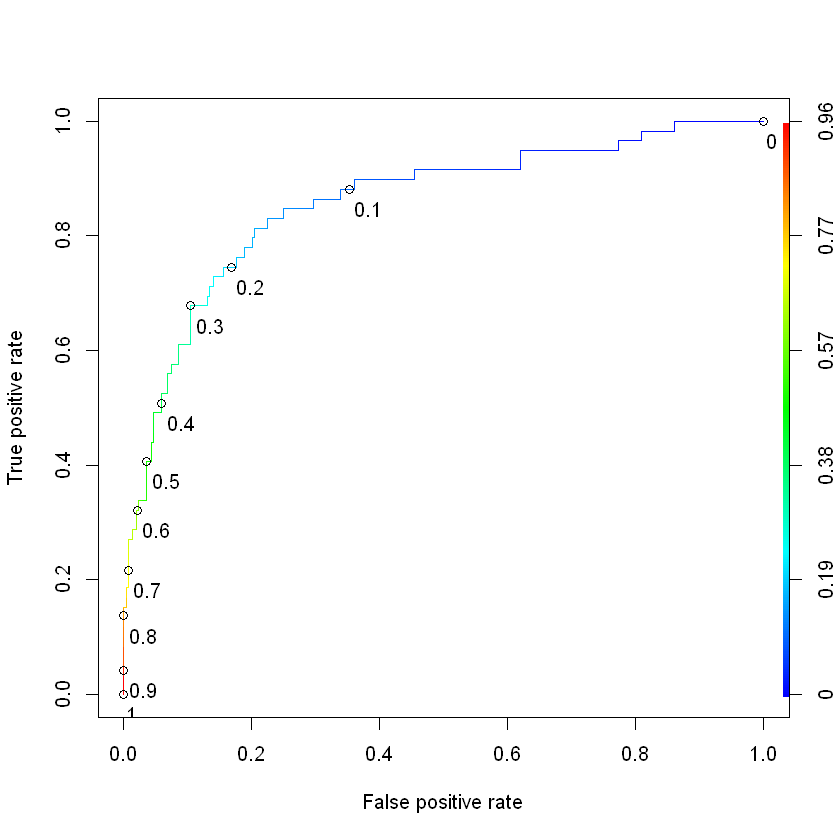

In [57]:
rocr_pred_log_imp_vars_new_ftr = prediction(predict_test_imp_log_new_ftr ,attrition_test_new$Attrition)
rocr_perf_log_imp_vars_new_ftr = performance(rocr_pred_log_imp_vars_new_ftr,'tpr','fpr')
plot(rocr_perf_log_imp_vars_new_ftr,colorize=TRUE,print.cutoffs.at = seq(0,1,.1),text.adj =c(-0.2,1.7))

In [58]:
threshold_log_imp_vars_new_ftr = 0.3
conf_mat_log_imp_vars_new_ftr <- table(attrition_test_new$Attrition ,predict_test_imp_log_new_ftr > threshold_log_imp_vars_new_ftr)
"Confusion matrix model with only important variable and new features"
conf_mat_log_imp_vars_new_ftr
# sensitivity tpr --> sensitivity = tp/(tp+FN)
tp <- conf_mat_log_imp_vars_new_ftr[4]
tp_plus_fn <- conf_mat_log_imp_vars_new_ftr[4] + conf_mat_log_imp_vars_new_ftr[2]

sensitivity_log_imp_vars_new_ftr <- tp/tp_plus_fn
print(c("sensitivity",sensitivity_log_imp_vars_new_ftr))

# specificity tnr--> specificity = tn/(tn+FP)
tn <- conf_mat_log_imp_vars_new_ftr[1]
tn_plus_fp <- conf_mat_log_imp_vars_new_ftr[1] + conf_mat_log_imp_vars_new_ftr[3]

specificity_log_imp_vars_new_ftr <- tn/tn_plus_fp
print(c("specificity",specificity_log_imp_vars_new_ftr))


#Predicting
# accuracy
accuracy_log_imp_vars_new_ftr <- (conf_mat_log_imp_vars_new_ftr[1] + conf_mat_log_imp_vars_new_ftr[4])/(conf_mat_log_imp_vars_new_ftr[1]+conf_mat_log_imp_vars_new_ftr[2]+conf_mat_log_imp_vars_new_ftr[3]+conf_mat_log_imp_vars_new_ftr[4])

print(c("Accuracy" ,accuracy_log_imp_vars_new_ftr))

kappa_log_imp_vars_new_ftr = confusionMatrix(factor(predict_test_imp_log_new_ftr > threshold_log_imp_vars_new_ftr), attrition_test_new$Attrition == 'Yes', positive="TRUE", mode="everything")
kappa_log_imp_vars_new_ftr = kappa_log_imp_vars_new_ftr$overall['Kappa']
print(c(kappa_log_imp_vars_new_ftr))

[1] "Confusion matrix model with only important variable and new features"

     
      FALSE TRUE
  No    276   32
  Yes    19   40

[1] "sensitivity"       "0.677966101694915"
[1] "specificity"       "0.896103896103896"
[1] "Accuracy"          "0.861035422343324"
    Kappa 
0.5271216 


We see that adding new feature has improved accuracy.

# Model Selection
There are many metrics which can be used to select the best model, choice of that metric is often done by cosidering  its impact on a business KPI.
For some business presision is important ,for others recall and in some cases overall acurracy might be important.


In [59]:
data.frame(list("model_name" = c("cart all variables","cart important variables","logistic all variables","logistic important variables","Logistic with feature engineering"),
                "Sensitivity" = c(sensitivity_cart,sensitivity_cart_model_imp_vars,sensitivity_logistic_best_treshold,sensitivity_log_imp_vars,sensitivity_log_imp_vars_new_ftr),
                "Specificity" = c(specificity_cart,specificity_cart_model_imp_vars,specificity_logistic_best_treshold,specificity_log_imp_vars,specificity_log_imp_vars_new_ftr),
               "Accuracy" = c(accuracy_cart,accuracy_cart_model_imp_vars,accuracy_logistic_best_treshold,accuracy_log_imp_vars,accuracy_log_imp_vars_new_ftr),
               "Kappa"= c(kappa_cart,kappa_cart_model_imp_vars,kappa_logistic_best_treshold,kappa_log_imp_vars,kappa_log_imp_vars_new_ftr)))

model_name,Sensitivity,Specificity,Accuracy,Kappa
cart all variables,0.3559322,0.9318182,0.8392371,0.3256828
cart important variables,0.4576271,0.9642857,0.8828338,0.4928170
logistic all variables,0.7627119,0.6720779,0.8692098,0.5737102
logistic important variables,0.6271186,0.8896104,0.8474114,0.4774738
Logistic with feature engineering,0.6779661,0.8961039,0.8610354,0.5271216


From the above statistics we conclude that for this use case:
    - CART with inclusion of only important variables outperforms other models in terms of overall accuracy.
    - Inclusion of new features after feature engineering increased the accuracy of Logistic regression model
    
    

### Complexity vs Performance
** Occam learning: **If you have two models/solutions both explaining the observed facts then you should use the simplest of them until more evidence comes along.
For example - 
- Model 1 - number of variables - 10,accuracy - 88% 
- Model 2 - number of variables - 7,accuracy - 84% 
Then Model 2 is preferred over Model 1

Another perspective of occam's razor is that for your model to give stable output once deployed we should try to take only sufficient variables in the model which give us 
a descent and explainable accuracy rather than taking some extremely volatile variables addition of which gives very little accuracy increment over the model with lesser variables.

In the above use case it was observed that while implementing logistic regression we can adopt Occam's learning to chose a lesser complex model i.e. _logistic important variables_ over _logistic all variables_

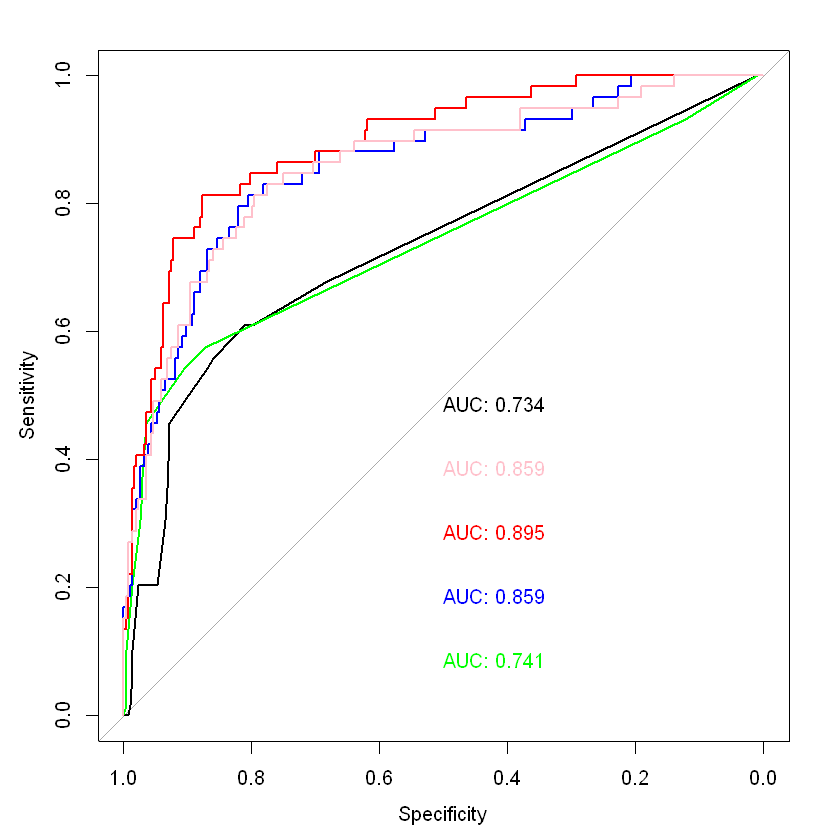

In [60]:
plot(roc(attrition_test$Attrition, predict_test_cart), print.auc=TRUE)
plot(roc(attrition_test$Attrition, predict_test_cart_model_imp_vars), print.auc = TRUE,col = "green", print.auc.y = .1, add = TRUE)
plot(roc(attrition_test$Attrition, predict_test_imp_log), print.auc = TRUE,col = "blue", print.auc.y = .2, add = TRUE)
plot(roc(attrition_test$Attrition, predict_test), print.auc = TRUE,col = "red", print.auc.y = .3, add = TRUE)
plot(roc(attrition_test$Attrition, predict_test_imp_log_new_ftr), print.auc = TRUE,col = "pink", print.auc.y = .4, add = TRUE)